# INFO 3401 – Class 26: Pointplots and heatmaps

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

Election day!

## Load libraries

Load our usual libraries.

In [6]:
# Data processing libraries
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# Geospatial libraries
import geopandas as gpd
from pyproj import CRS
import contextily, geoplot

import matplotlib.colors as colors

## Load data

We're going to use data from the Colorado Secretary of State:

* [2020 live results](https://results.enr.clarityelections.com/CO/105975/web.264614/#/summary) - Reports > Detail XLS
* [Election archives](https://www.sos.state.co.us/pubs/elections/Results/archive2000.html) - "General Election results in Excel format (XLSX)"

In [7]:
co_results_2016_df = pd.read_excel('co_2016_county_results.xlsx')
co_results_2016_df.head()

,OFFICE / BALLOT ISSUE,PARTY,COUNTY,CANDIDATE / BALLOT ISSUE TITLE,YES VOTES,YES PERCENT,NO VOTES,NO PERCENT
0,President/Vice President,Democratic Party,ADAMS,Hillary Clinton / Tim Kaine,96558,0.0347,NaN,NaN
1,President/Vice President,Democratic Party,ALAMOSA,Hillary Clinton / Tim Kaine,3189,0.0011,NaN,NaN
2,President/Vice President,Democratic Party,ARAPAHOE,Hillary Clinton / Tim Kaine,159885,0.0575,NaN,NaN
3,President/Vice President,Democratic Party,ARCHULETA,Hillary Clinton / Tim Kaine,2500,0.0009,NaN,NaN
4,President/Vice President,Democratic Party,BACA,Hillary Clinton / Tim Kaine,283,0.0001,NaN,NaN


In [21]:
co_results_2020_238_df = pd.read_excel('co_2020_county_results.xlsx',
                                       sheet_name=238,
                                       skiprows=[0,1])
co_results_2020_238_df.head()

,County,Registered Voters,Total Votes,Total Votes.1,Total Votes.2,Total Votes.3,Total
0,Adams,278866,108273,108273,101635,101635,209908
1,Alamosa,10492,2722,2722,4592,4592,7314
2,Arapahoe,399844,161918,161918,143223,143223,305141
3,Archuleta,11481,3084,3084,5571,5571,8655
4,Baca,2921,388,388,1700,1700,2088


Time permitting, we'll also use data from the 2018 ACS 5-year estimates of demographics about Colorado counties:
* [ACS Demographics](https://data.census.gov/cedsci/table?q=DP5&text=DP05&t=Populations%20and%20People&g=0400000US08.050000&tid=ACSDP5Y2018.DP05&moe=false&hidePreview=true)

In [ ]:
acs_df = pd.read_csv('ACS_2018_DP05_co_counties.csv')

The fields are coded but the metadata is available in an accompanying file.

In [ ]:
acs_metadata_df = pd.read_csv('ACS_2018_DP05_co_counties_metadata.csv')

Finally load the Colorado counties and convert the "county" name to title-case.

In [28]:
co_counties_gdf = gpd.read_file('co_counties/co_counties.shp')

co_counties_gdf['county'] = co_counties_gdf['county'].str.title()

co_counties_gdf.head(1)

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry
0,1.0,Adams,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9..."


## Feature engineering

Calculate vote share for wolves by county.

In [22]:
# Renaming columns
co_results_2020_238_df.columns = ['County','Registered','Yes','Yes again','No','No again','Total']

In [27]:
# Calculate voteshare
co_results_2020_238_df['Yes share'] = co_results_2020_238_df['Yes']/co_results_2020_238_df['Total']

# Drop bad rows
# co_results_2020_238_df.drop(64,inplace=True)

# Inspect
co_results_2020_238_df.head()

,County,Registered,Yes,Yes again,No,No again,Total,Yes share
0,Adams,278866,108273,108273,101635,101635,209908,0.515812
1,Alamosa,10492,2722,2722,4592,4592,7314,0.372163
2,Arapahoe,399844,161918,161918,143223,143223,305141,0.530633
3,Archuleta,11481,3084,3084,5571,5571,8655,0.356326
4,Baca,2921,388,388,1700,1700,2088,0.185824


## Merge co_counties with co_results_238

In [32]:
merged_counties_238_gdf = pd.merge(left = co_counties_gdf,
                                   right = co_results_2020_238_df,
                                   how = 'outer',
                                   left_on = 'county',
                                   right_on = 'County'
                                  )

merged_counties_238_gdf.head()

,co_fips,county,househo_20,pop_2010,shape_st_1,shape_st_2,shape_star,shape_stle,geometry,County,Registered,Yes,Yes again,No,No again,Total,Yes share
0,1.0,Adams,154502.0,441603.0,3.064413e+09,392729.110497,0.0,0.0,"POLYGON ((-103.70574 39.99991, -103.70569 39.9...",Adams,278866,108273,108273,101635,101635,209908,0.515812
1,3.0,Alamosa,6008.0,15445.0,1.872295e+09,177555.351470,0.0,0.0,"POLYGON ((-105.59917 37.75216, -105.51619 37.7...",Alamosa,10492,2722,2722,4592,4592,7314,0.372163
2,5.0,Arapahoe,225124.0,572003.0,2.084863e+09,335003.471310,0.0,0.0,"MULTIPOLYGON (((-103.70653 39.73986, -103.7066...",Arapahoe,399844,161918,161918,143223,143223,305141,0.530633
3,7.0,Archuleta,5257.0,12084.0,3.504795e+09,263558.683443,0.0,0.0,"POLYGON ((-107.12854 37.42287, -107.12881 37.3...",Archuleta,11481,3084,3084,5571,5571,8655,0.356326
4,11.0,Bent,1835.0,6499.0,3.990976e+09,254662.200852,0.0,0.0,"POLYGON ((-102.74208 38.26675, -102.74211 38.2...",Bent,3208,732,732,1426,1426,2158,0.339203


In [30]:
type(merged_counties_238_gdf)

geopandas.geodataframe.GeoDataFrame

In [36]:
merged_counties_238_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

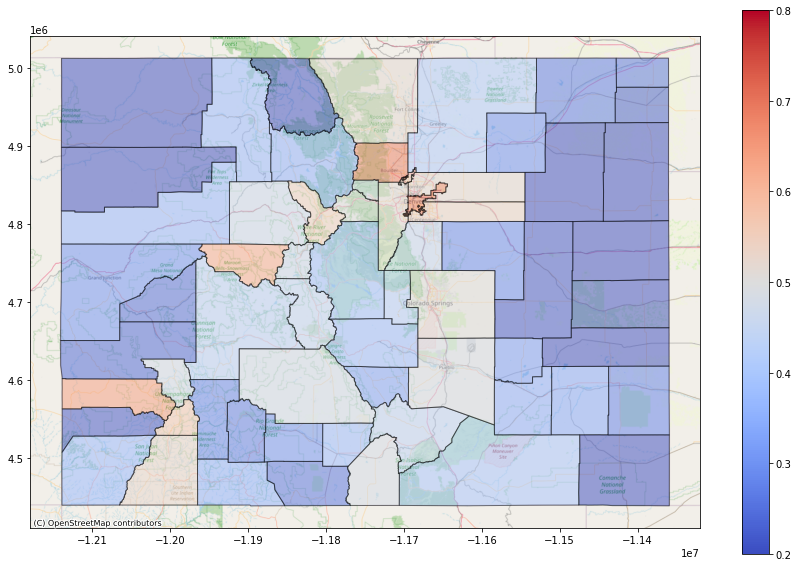

In [52]:
f,ax = plt.subplots(1,1,figsize=(15,10))

_gdf = merged_counties_238_gdf.to_crs(epsg='3857')

_gdf.plot(column = 'Yes share',
                             legend = True,
                             vmin=.2,
                             vmax=.8,
                             cmap='coolwarm',
          edgecolor = 'k',
          alpha=.5,
                             ax = ax)

contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik)